## Get data

In [1]:
#imports
from astroquery.gaia import Gaia
import pandas as pd 
import seaborn as sns
import math
import matplotlib.pyplot as plt

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


In [2]:
#gaia query

job = Gaia.launch_job_async("SELECT ALL gaia_source.source_id,gaia_source.ra,gaia_source.dec,\
gaia_source.pmra,gaia_source.pmdec,gaia_source.phot_bp_mean_mag FROM gaiadr2.gaia_source WHERE CONTAINS\
(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',229.226,7.002,0.3))=1")  
                           # AND  \(gaiadr2.gaia_source.phot_bp_mean_mag<=20)")

WARNING

Query finished.


: W50: None:26:0: W50: Invalid unit string 'mas.yr**-1' [astropy.io.votable.tree]


In [3]:
#get resulting gaia datatable
r = job.get_results() #print(r['ra','dec'])
df_gaia = r.to_pandas()

In [4]:
#read apt datatable
filename = "pi26133_001.csv"
df_apt_ = pd.read_csv(filename) 
df_apt = df_apt_[['CentroidRA', 'CentroidDec','Magnitude', 'MagUncertainty']]

## Plots

Text(0.5,1,'Position match')

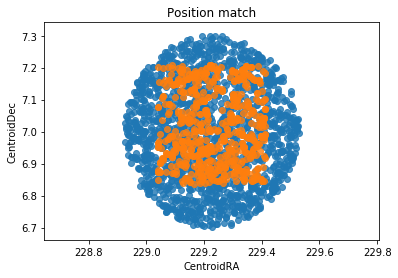

In [5]:
#check ra and dec matching
sns.regplot('ra', 'dec', data=df_gaia, fit_reg = False)
sns.regplot('CentroidRA', 'CentroidDec', data=df_apt, fit_reg = False).set_title("Position match")

In [11]:
#set diff
maxdiff = 0.0050 #degree

m = 0
df_gaia = df_gaia.sort_values('ra').reset_index(drop=True)
df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
df = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag','CentroidRA','CentroidDec','Magnitude','diff','pmra','pmdec'])

while m < len(df_apt):
    n = 0
    df_temp = pd.DataFrame(columns=['ra','dec','phot_bp_mean_mag'])
    while n<len(df_gaia):
        if df_apt['CentroidRA'][m] - maxdiff > df_gaia['ra'][n]: 
            n+=1
        elif df_apt['CentroidRA'][m] - maxdiff <= df_gaia['ra'][n] <= df_apt['CentroidRA'][m] + maxdiff :
            if df_apt['CentroidDec'][m] - maxdiff <= df_gaia['dec'][n] <= df_apt['CentroidDec'][m] + maxdiff :
                df_temp = df_temp.append({'ra': df_gaia['ra'][n], 'dec': df_gaia['dec'][n], \
                                          'phot_bp_mean_mag': df_gaia['phot_bp_mean_mag'][n], \
                                          'pmra': df_gaia['pmra'][n],'pmdec': df_gaia['pmdec'][n],\
                                          'diff':  math.sqrt((df_gaia['ra'][n]-df_apt['CentroidRA'][m])**2+\
                                                             (df_gaia['dec'][n]-df_apt['CentroidDec'][m])**2)},\
                                         ignore_index=True)
            n+=1
        else :
            break
    if m == 0:
        print('Started. Progress:')
    elif m == int(len(df_apt)/10):
        print(' 10% | ██--------------')
    elif m == int(len(df_apt)/4):
        print(' 25% | ████------------')
    elif m == int(len(df_apt)/2):
        print(' 50% | ████████--------')
    elif m == int(len(df_apt)/4*3):
        print(' 75% | ████████████----')
    elif m == len(df_apt)-1:
        print('100% | ████████████████')
    if df_temp.empty == False : 
        df_temp = df_temp.nsmallest(1, 'diff').reset_index(drop=True)
        df = df.append({'ra': df_temp['ra'][0], \
                    'dec': df_temp['dec'][0],\
                    'phot_bp_mean_mag': df_temp['phot_bp_mean_mag'][0],\
                    'pmra': df_temp['pmra'][0], 'pmdec': df_temp['pmdec'][0],\
                    'CentroidRA': df_apt['CentroidRA'][m],\
                    'CentroidDec': df_apt['CentroidDec'][m],\
                    'Magnitude': df_apt['Magnitude'][m],\
                    'diff': df_temp['diff'][0]}, ignore_index=True)
    m+=1
print('Finished')

Started. Progress:
 10% | ██--------------
 25% | ████------------
 50% | ████████--------
 75% | ████████████----
100% | ████████████████
Finished


/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'Distribution of difference in match')

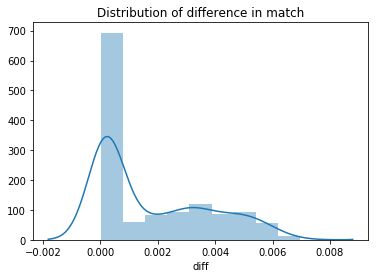

In [12]:
sns.distplot(df['diff']).set_title('Distribution of difference in match')

In [13]:
#new vars
df['Δra'] = df.apply(lambda row: row.ra - row.CentroidRA, axis = 1) 
df['Δdec'] = df.apply(lambda row: row.dec - row.CentroidDec, axis = 1) 
df['Δmag'] = df.apply(lambda row: row.Magnitude - row.phot_bp_mean_mag, axis = 1) 

#subset
df_filtered = df.query('diff<0.001')

/Users/Lyy/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,1,'dec vs. Δdec')

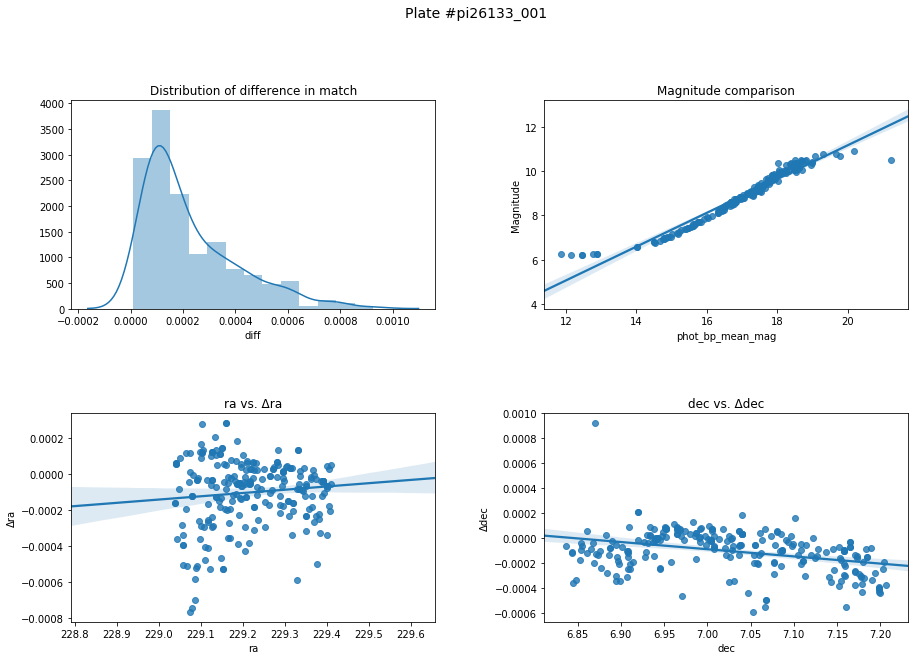

In [16]:
fig = plt.figure(figsize=(15,10))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3, hspace=0.5)

ax1 = fig.add_subplot(2,2,1)
#sns.distplot(df['diff']).set_title('Distribution of difference in match')
sns.distplot(df_filtered['diff']).set_title('Distribution of difference in match')
ax2 = fig.add_subplot(2,2,2)
#sns.regplot('phot_bp_mean_mag','Magnitude',data=df, fit_reg = False).set_title('Magnitude comparison')
sns.regplot('phot_bp_mean_mag','Magnitude',data=df_filtered).set_title('Magnitude comparison')
ax3 = fig.add_subplot(2,2,3)
#sns.regplot('ra','Δra',data=df).set_title('ra vs. Δra')
sns.regplot('ra','Δra',data=df_filtered).set_title('ra vs. Δra')
ax4 = fig.add_subplot(2,2,4)
#sns.regplot('dec','Δdec',data=df).set_title('dec vs. Δdec')
sns.regplot('dec','Δdec',data=df_filtered).set_title('dec vs. Δdec')

Text(0.5,1,'pmdec vs. Δdec')

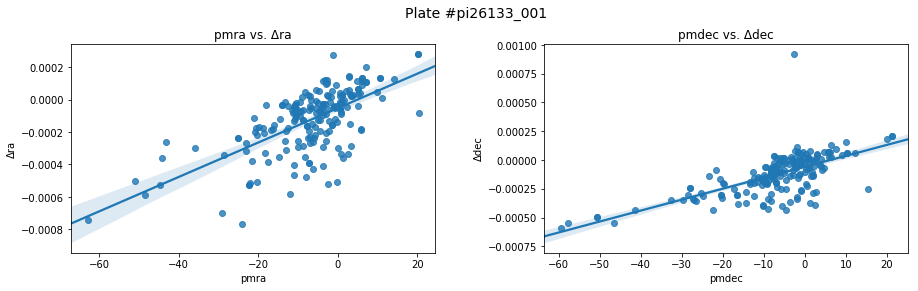

In [17]:
fig = plt.figure(figsize=(15,4))
title = fig.suptitle("Plate #pi26133_001", fontsize=14)
fig.subplots_adjust(top=0.85, wspace=0.3)

ax1 = fig.add_subplot(1,2,1)
#sns.regplot('pmra','Δra',data=df).set_title('pmra vs. Δra')
sns.regplot('pmra','Δra',data=df_filtered).set_title('pmra vs. Δra')

ax2 = fig.add_subplot(1,2,2)
#sns.regplot('pmdec','Δdec',data=df).set_title('pmdec vs. Δdec')
sns.regplot('pmdec','Δdec',data=df_filtered).set_title('pmdec vs. Δdec')